# Hypothesis Testing

Section: d. US versus the rest of the world in total purchases per customer

**Part of:** [marketing_campaign_082825_working.ipynb](./marketing_campaign_082825_working.ipynb)

In [1]:
# Setup and data loading
from utils import (
    ProjectConfig,
    load_intermediate_results,
    save_project_figure,
    reset_plot_settings,
)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

config = ProjectConfig()
# Load data from previous notebook
df = load_intermediate_results("data_from_08_step_6.pkl", config)


## d. US versus the rest of the world in total purchases per customer

In [2]:
# d. US vs rest of world in total purchases per customer

# Specify H₀ and H₁:
# H₀: The distributions of Total_Puchases for US and non-US customers are
#     identical (no difference in distribution).
# H₁: The distribution of Total_Purchases for US customers is stochastically
#     greater (US tends to have higher Total_Purchases for its customers).

# Normality and Test Choice:
# •  Use the t-test if Total_Puchases is approximately normally distributed.
# •  Use the Mann-Whitney U test if the data is non-normal.

# Interpreting Results:
# •  P-value ≤ α (0.05): Reject H₀, concluding there is evidence that US has higher
#    Total_Purchases for its customers than the rest of the world.
# •  P-value > α: Fail to reject H₀, indicating insufficient evidence that US has higher
#    Total_Purchases for its customers than the rest of the world.

In [3]:
# Split data
us_purchases = df[df['Country_US'] == 1]['Total_Purchases']
non_us_purchases = df[df['Country_US'] == 0]['Total_Purchases']

In [4]:
# Normality check
from scipy.stats import shapiro

# Purpose:
# •  Tests the null hypothesis (H₀) that the data from the groups is normally distributed.
# •  Alternative hypothesis (H₁): The data is not normally distributed.

for group, data in [(1, us_purchases), (0, non_us_purchases)]:
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test for Country_US = {group}: p-value = {p:.4f}")
    if p < 0.05:
        print("  p-value < 0.05: Reject H₀, data is not normally distributed.")
    else:
        print("  p-value >= 0.05: Fail to reject H₀, data may be normally distributed.")

Shapiro-Wilk Test for Country_US = 1: p-value = 0.0023
  p-value < 0.05: Reject H₀, data is not normally distributed.
Shapiro-Wilk Test for Country_US = 0: p-value = 0.0000
  p-value < 0.05: Reject H₀, data is not normally distributed.


Saved: figures\Total_Purchase_US_vs_Rest_of_the_World.png


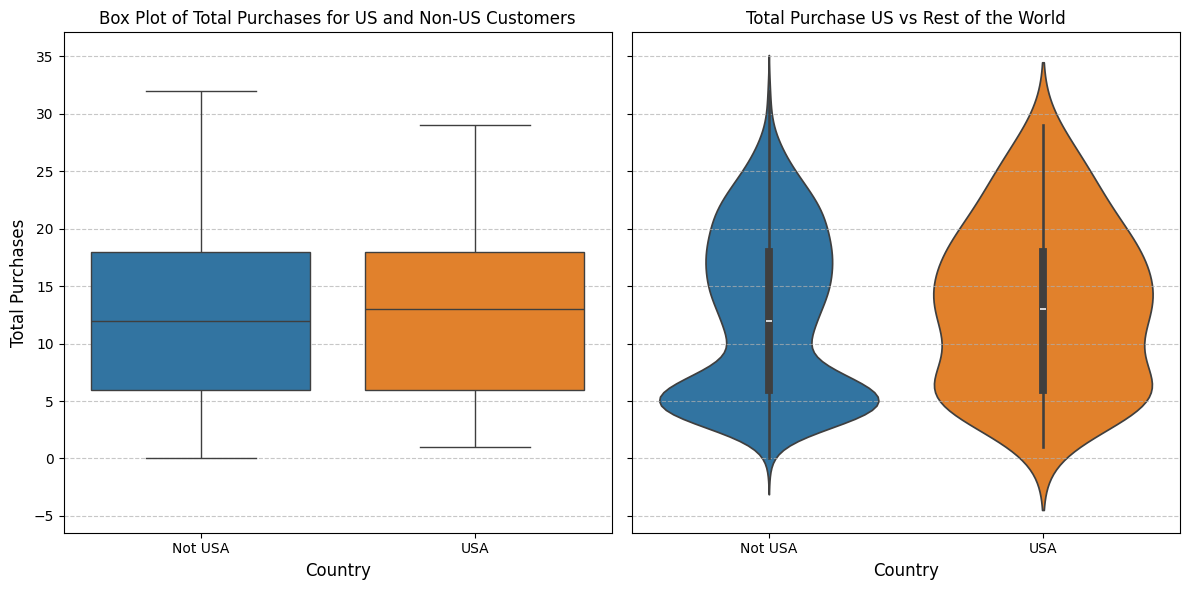

                 mean  median       std  count
Country_US                                    
False       12.507308    12.0  7.190538   2121
True        13.370370    13.0  6.989435    108


In [5]:
# Create a figure with two subplots side by side

reset_plot_settings()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

# Boxplot
sns.boxplot(x='Country_US', y='Total_Purchases', data=df, ax=ax1, hue='Country_US', legend=False)
ax1.set_title("Box Plot of Total Purchases for US and Non-US Customers", fontsize=12)
ax1.set_ylabel("Total Purchases", fontsize=12)
ax1.set_xlabel('Country', fontsize=12)
ax1.set_xticks([0,1], ['Not USA', 'USA'])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Violin Plot
sns.violinplot(x='Country_US', data=df, y='Total_Purchases', legend=False, ax=ax2, hue='Country_US')
ax2.set_title("Violin Plot of Total Purchases for US and Non-US Customers", fontsize=12)
ax2.set_xlabel('Country', fontsize=12)
ax2.set_xticks([0,1], ['Not USA', 'USA'])
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
save_project_figure(
    "Total_Purchase_US_vs_Rest_of_the_World",
    "Total Purchase US vs Rest of the World",
    config,
)
plt.show()

# Descriptive Statistics
stats = df.groupby('Country_US')['Total_Purchases'].agg(['mean','median','std','count'])
print(stats)

# Shapiro-Wilk test and plots show data is not normally distributed so a non-parametric
# test seems more appropriate

In [6]:
# Perform Mann-Whitney U Test (One-Tailed)
# H₀: The distributions of Total_Puchases for US and non-US customers are
#     identical (no difference in distribution).
# H₁: The distribution of Total_Purchases for US customers is stochastically
#     greater (US tends to have higher Total_Purchases for its customers).
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(us_purchases, non_us_purchases, alternative='greater')
print(f'Mann-Whitney U Test: statistic = {stat:.4f}, p-value = {p_value:.4f}')

# Interpretation
alpha = 0.05
if p_value <= alpha:
    print('Reject H₀: Reject H₀, concluding there is evidence that US has higher Total_Purchases for its customers than the rest of the world.')
else:
    print('Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world.')

Mann-Whitney U Test: statistic = 122899.5000, p-value = 0.0996
Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world.


In [7]:
# Why a t-test may be ok
# Large sample sizes (e.g., n > 30 or ideally n > 50 per group), due to the Central Limit Theorem (CLT).
# The CLT states that the sampling distribution of the mean approaches normality as sample size increases,
# even if the underlying data is non-normal.

print(f"Sample size for Country:\n{df['Country_US'].value_counts()}")
# Sample Size is Large: Both groups (Country_US = 1 and 0) have n > 50
# the CLT helps ensure the t-test is robust.

Sample size for Country:
Country_US
False    2121
True      108
Name: count, dtype: int64


In [8]:
# Perform Levene's test

# Purpose:
# •  Tests the null hypothesis (H₀) that the variances of the groups are equal.
# •  Alternative hypothesis (H₁): The variances are not equal.

# Variations of test:
# •  Standard Levene’s Test: Uses the group mean for calculating deviations.
# •  Modified Levene’s Test (Brown-Forsythe): Uses the group median instead of the mean,
#    which is more robust to non-normal data.

# Implications of test:
# •  If Levene’s test indicates unequal variances (p-value ≤ 0.05), use Welch’s t-test to compare means.
# •  If variances are equal, use the standard t-test.

from scipy.stats import levene
alpha = 0.05

stat, p_levene = levene(us_purchases, non_us_purchases, center='median')
print(f"\nLevene's Test: statistic = {stat:.4f}, p-value = {p_levene:.4f}")
print(f"{'Unequal variances' if p_levene < alpha else 'Equal variances'} (p {'<' if p_levene < alpha else '>='} {alpha})")


Levene's Test: statistic = 1.8860, p-value = 0.1698
Equal variances (p >= 0.05)


In [9]:
# Run standard parametric t-test since variances are equal

from scipy.stats import ttest_ind
print("\nStandard t-Test:")
stat, p_ttest = ttest_ind(us_purchases, non_us_purchases, alternative='greater', equal_var=True)
print(f"t-test: statistic = {stat:.4f}, p-value = {p_ttest:.4f}")

if p_ttest <= alpha:
    print('Reject H₀: Reject H₀, concluding there is evidence that US has higher Total_Purchases for its customers than the rest of the world.')
else:
    print('Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world.')


Standard t-Test:
t-test: statistic = 1.2184, p-value = 0.1116
Fail to reject H₀: No evidence that US has higher Total_Purchases for its customers than the rest of the world.


In [10]:
# Conclusion
# Both the parametric test (Standard t-Test) and the non-parametric test (Mann-Whitney U Test)
# fail to reject H₀, meaning there is no evidence that Total_Purchases for US customers is greater than Total_Purchases for Non US Customers

In [11]:

# Save results for next notebook
# save_intermediate_results(df_processed, 'processed_data.pkl', config)
# save_intermediate_results(analysis_results, 'analysis_results.pkl', config)
# print('✓ Results saved for next notebook')